In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import * 
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from urllib.request import urlretrieve
from owslib.wfs import WebFeatureService
from dotenv import load_dotenv
from pyspark.sql import functions as F

# Create a spark session
spark = (
    SparkSession.builder.appName("analysis")
    .config("spark.sql.repl.eagerEval.enabled", True) 
    .config("spark.sql.parquet.cacheMetadata", "true")
    .config("spark.sql.session.timeZone", "Etc/UTC")
    .config("spark.driver.memory", "2g")
    .config("spark.executor.memory", "6g")
    .getOrCreate()
)

22/09/26 21:49:00 WARN Utils: Your hostname, AryansLaptop resolves to a loopback address: 127.0.1.1; using 172.25.90.88 instead (on interface eth0)
22/09/26 21:49:00 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


22/09/26 21:49:02 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
22/09/26 21:49:03 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


In [2]:
postcode_sdf = spark.read.parquet("../data/curated/postcodedf.parquet/")
print(postcode_sdf.count())
postcode_sdf.limit(5)

5492


postcode,sa2_code
1008,117031337
1150,117031337
2100,122031429
2200,119011571
2338,110041201


## Join postcode data with population data

In [3]:
pop_sdf = spark.read.parquet("../data/curated/pop_sdf.parquet/")
print(pop_sdf.count())
populationdf = pop_sdf.withColumnRenamed("SA2 code","sa2_code")
populationdf.limit(5)

2450


State/Terr,sa2_code,SA2 name,Total,Under 10,Adolescent,Young adult,Middle age,Old
New South Wales,121011686,Lane Cove,15931,2246,1683,3108,5838,3056
New South Wales,121011687,Willoughby,13024,1829,1862,1679,4949,2705
New South Wales,121021403,Asquith - Mount C...,22134,2949,3092,3674,8221,4198
New South Wales,121021404,Berowra - Brookly...,11793,1513,1805,1444,4385,2646
New South Wales,121021406,Normanhurst - Tho...,19199,2395,2868,2589,6962,4385


In [4]:
merged_sdf1 = populationdf.join(postcode_sdf, on="sa2_code", how="inner")

In [5]:
merged_sdf1.groupBy("sa2_code").count().count()

2083

Lost 367 records for which there were no sa2 codes

In [6]:
merged_sdf1.orderBy("postcode").limit(5)

sa2_code,State/Terr,SA2 name,Total,Under 10,Adolescent,Young adult,Middle age,Old,postcode
801051049,Australian Capita...,Acton,2875,6,1528,1292,47,2,0200
701011002,Northern Territory,Darwin City,7679,474,325,3322,2652,906,0800
701011002,Northern Territory,Darwin City,7679,474,325,3322,2652,906,0801
701011007,Northern Territory,Parap,2980,350,282,801,1047,500,0804
701021013,Northern Territory,Brinkin - Nakara,3615,372,409,1140,1086,608,0810


Get a single population value for each postcode and field by calculating the mean

In [7]:
postcode_pop_sdf = merged_sdf1.groupBy("postcode") \
    .agg(
        F.round(F.mean(merged_sdf1.Total), 2).alias("total_pop"),
        F.round(F.mean(merged_sdf1['Under 10']), 2).alias("under10_pop"),
        F.round(F.mean(merged_sdf1.Adolescent), 2).alias("adolsc_pop"),
        F.round(F.mean(merged_sdf1['Young adult']), 2).alias("yng_adult_pop"),
        F.round(F.mean(merged_sdf1['Middle age']), 2).alias("mid_age_pop"),
        F.round(F.mean(merged_sdf1.Old), 2).alias("old_pop")
    )
    
postcode_pop_sdf.orderBy("postcode").show()

+--------+---------+-----------+----------+-------------+-----------+-------+
|postcode|total_pop|under10_pop|adolsc_pop|yng_adult_pop|mid_age_pop|old_pop|
+--------+---------+-----------+----------+-------------+-----------+-------+
|    0200|   2875.0|        6.0|    1528.0|       1292.0|       47.0|    2.0|
|    0800|   7679.0|      474.0|     325.0|       3322.0|     2652.0|  906.0|
|    0801|   7679.0|      474.0|     325.0|       3322.0|     2652.0|  906.0|
|    0804|   2980.0|      350.0|     282.0|        801.0|     1047.0|  500.0|
|    0810|   3018.0|      419.0|    346.08|       769.08|    1013.67| 470.17|
|    0811|   3615.0|      372.0|     409.0|       1140.0|     1086.0|  608.0|
|    0812|  3314.67|     483.33|     447.0|       636.83|    1143.67| 603.83|
|    0813|   2516.0|      468.0|     454.0|        729.0|      664.0|  201.0|
|    0814|   4112.0|      490.0|     393.0|       1204.0|     1371.0|  654.0|
|    0815|   3615.0|      372.0|     409.0|       1140.0|     10

Visualize the population variation for each SA2 code within each postcode

In [8]:
pop_diffs = merged_sdf1.groupBy("postcode").agg(
    (F.max(merged_sdf1.Total) - F.min(merged_sdf1.Total)).alias("Total"),
    (F.max(merged_sdf1["Under 10"]) - F.min(merged_sdf1["Under 10"])).alias("Under 10"),
    (F.max(merged_sdf1.Adolescent) - F.min(merged_sdf1.Adolescent)).alias("Adolescent"),
    (F.max(merged_sdf1["Young adult"]) - F.min(merged_sdf1["Young adult"])).alias("Young adult"),
    (F.max(merged_sdf1["Middle age"]) - F.min(merged_sdf1["Middle age"])).alias("Middle age"),
    (F.max(merged_sdf1.Old) - F.min(merged_sdf1.Old)).alias("Old")
)

In [9]:
pop_diffs.limit(5)

postcode,Total,Under 10,Adolescent,Young adult,Middle age,Old
2069,0,0,0,0,0,0
2162,0,0,0,0,0,0
2756,19732,2529,3149,3627,6542,5045
2110,0,0,0,0,0,0
2161,23111,3744,3352,5588,7015,3840


/tmp/ipykernel_5711/1227780644.py:3: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_yticklabels(['Total', 'Under 10',


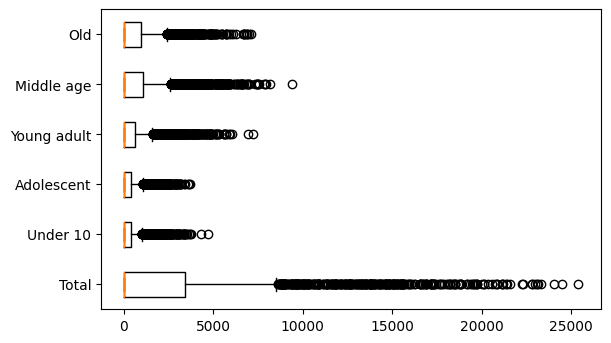

In [10]:
fig1 = plt.figure(figsize = (5, 3))
ax1 = fig1.add_axes([0, 0, 1, 1])
ax1.set_yticklabels(['Total', 'Under 10',
                    'Adolescent', 'Young adult',
                    'Middle age', 'Old'])
bp = ax1.boxplot(pop_diffs.drop("postcode").toPandas(), vert=0)

plt.show()

## Join postcode data with income data

In [11]:
incomedf = spark.read.parquet("../data/curated/incomedf.parquet/")
print(incomedf.count())
incomedf.limit(5)

2239


sa2_code,num_earners,median_age,median_income,mean_income
213011340,11238,46,51181,61177
213021341,7942,43,57585,69301
213021344,11216,41,66161,80219
213021345,3015,41,52078,60249
213021346,9996,47,63892,90668


In [12]:
merged_sdf2 = incomedf.join(postcode_sdf, on="sa2_code", how="inner")

In [13]:
merged_sdf2.groupBy("sa2_code").count().count()

2186

Lost 53 records for which there were no sa2 codes

In [14]:
merged_sdf2.orderBy("postcode").limit(5)

sa2_code,num_earners,median_age,median_income,mean_income,postcode
801051049,548,23,9306,16835,0200
701011002,5909,33,60937,87791,0800
701011002,5909,33,60937,87791,0801
701011007,1873,40,75219,98872,0804
701021024,1229,41,58778,65990,0810


Again, use the mean approach for the income data

In [15]:
postcode_income_sdf = merged_sdf2.groupBy("postcode") \
    .agg(
        F.round(F.mean(merged_sdf2.num_earners), 2).alias("num_earners"),
        F.round(F.mean(merged_sdf2.median_age), 2).alias("median_age"),
        F.round(F.mean(merged_sdf2.median_income), 2).alias("median_income"),
        F.round(F.mean(merged_sdf2.mean_income), 2).alias("mean_income")
    )
    
postcode_income_sdf.orderBy("postcode").show()

+--------+-----------+----------+-------------+-----------+
|postcode|num_earners|median_age|median_income|mean_income|
+--------+-----------+----------+-------------+-----------+
|    0200|      548.0|      23.0|       9306.0|    16835.0|
|    0800|     5909.0|      33.0|      60937.0|    87791.0|
|    0801|     5909.0|      33.0|      60937.0|    87791.0|
|    0804|     1873.0|      40.0|      75219.0|    98872.0|
|    0810|    1823.33|     39.33|      59558.0|   69537.42|
|    0811|     2395.0|      39.0|      52335.0|    67299.0|
|    0812|     2330.2|      41.6|      62069.0|    69623.6|
|    0813|      296.0|      35.0|      35787.0|    44160.0|
|    0814|     2618.0|      39.0|      65946.0|    81123.0|
|    0815|     2395.0|      39.0|      52335.0|    67299.0|
|    0820|    2223.55|     41.09|     58518.91|   75577.27|
|    0821|     3585.0|      39.0|      51942.0|    69250.0|
|    0822|    1787.38|     39.06|     49168.06|   59432.69|
|    0828|      686.0|      43.0|      5

Visualize the income variation for each SA2 code within each postcode

In [16]:
income_diffs = merged_sdf2.groupBy("postcode").agg(
    (F.max(merged_sdf2.num_earners) - F.min(merged_sdf2.num_earners)).alias("num_earners"),
    (F.max(merged_sdf2.median_age) - F.min(merged_sdf2.median_age)).alias("median_age"),
    (F.max(merged_sdf2.median_income) - F.min(merged_sdf2.median_income)).alias("median_income"),
    (F.max(merged_sdf2.mean_income) - F.min(merged_sdf2.mean_income)).alias("mean_income")
)

In [17]:
income_diffs.limit(5)

postcode,num_earners,median_age,median_income,mean_income
3414,0,0,0,0
4032,2182,8,4402,6670
9009,0,0,0,0
3015,0,0,0,0
5523,3242,2,4299,4030


/tmp/ipykernel_5711/3120451410.py:3: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_yticklabels(['num_earners', 'median_age',


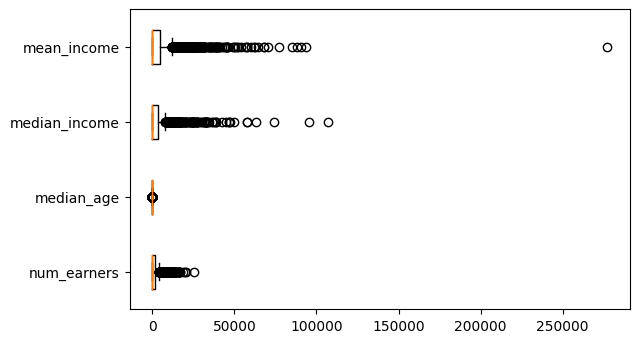

In [18]:
fig2 = plt.figure(figsize = (5, 3))
ax2 = fig2.add_axes([0, 0, 1, 1])
ax2.set_yticklabels(['num_earners', 'median_age',
                    'median_income', 'mean_income'])
bp = ax2.boxplot(income_diffs.drop("postcode").toPandas(), vert=0)

plt.show()

Combine all external data in a single spark dataframe

In [19]:
print(postcode_pop_sdf.count(), postcode_income_sdf.count())

2793 3160


In [20]:
external_data_sdf = postcode_pop_sdf.join(postcode_income_sdf, on="postcode", how="full")
print(external_data_sdf.count())
external_data_sdf.limit(5)

3162


postcode,total_pop,under10_pop,adolsc_pop,yng_adult_pop,mid_age_pop,old_pop,num_earners,median_age,median_income,mean_income
0200,2875.0,6.0,1528.0,1292.0,47.0,2.0,548.0,23.0,9306.0,16835.0
0800,7679.0,474.0,325.0,3322.0,2652.0,906.0,5909.0,33.0,60937.0,87791.0
0801,7679.0,474.0,325.0,3322.0,2652.0,906.0,5909.0,33.0,60937.0,87791.0
0804,2980.0,350.0,282.0,801.0,1047.0,500.0,1873.0,40.0,75219.0,98872.0
0810,3018.0,419.0,346.08,769.08,1013.67,470.17,1823.33,39.33,59558.0,69537.42


## Join External data with existing data

In [21]:
sdf = spark.read.parquet("../data/curated/mergedf.parquet/")
print(sdf.count())
sdf.limit(5)

13613661


merchant_abn,consumer_id,user_id,dollar_value,order_id,order_datetime,customer_name,address,state,postcode,gender,company_name,tags,take_rate,revenue_band
69666829657,226,5162,79.65159982605903,8765ef9f-dba6-407...,2021-08-20,Courtney Torres,6945 Higgins Brooks,SA,5581,Female,Sem Ut Institute,bicycle shops - s...,2.86,c
50321300271,226,5162,594.2915496790856,79f2842d-f8b2-4fd...,2022-06-01,Courtney Torres,6945 Higgins Brooks,SA,5581,Female,Augue Industries,bicycle shops - s...,4.24,b
70610974780,226,5162,52.820359204536665,bdf345c8-4c5d-48e...,2021-08-20,Courtney Torres,6945 Higgins Brooks,SA,5581,Female,Elit Aliquam PC,tent and awning s...,6.93,a
17324645993,226,5162,27.12729568273566,0a44d623-e325-4fc...,2022-05-12,Courtney Torres,6945 Higgins Brooks,SA,5581,Female,Eget Metus In Cor...,tent and awning s...,5.73,a
15582655078,226,5162,75.31904078962366,47ddf8e0-5f72-408...,2021-08-21,Courtney Torres,6945 Higgins Brooks,SA,5581,Female,Eu Odio Phasellus...,"gift, card, novel...",6.77,a


In [22]:
finaldf = sdf.join(external_data_sdf, on="postcode", how="inner")
print(finaldf.count())
finaldf.limit(5)

13394287


postcode,merchant_abn,consumer_id,user_id,dollar_value,order_id,order_datetime,customer_name,address,state,gender,company_name,tags,take_rate,revenue_band,total_pop,under10_pop,adolsc_pop,yng_adult_pop,mid_age_pop,old_pop,num_earners,median_age,median_income,mean_income
6731,71350572766,58911,22131,38.35886219595664,fd0cfc42-44b3-467...,2021-09-18,Paul Lopez,3908 David Squares,WA,Male,Dictum Placerat A...,"cable, satellite,...",1.57,c,8374.0,1373.0,1185.0,2200.0,2600.0,1016.0,2907.0,39.0,48034.0,56306.0
6731,96680767841,58911,22131,415.9547984625,829843bc-c571-493...,2021-08-19,Paul Lopez,3908 David Squares,WA,Male,Ornare Limited,motor vehicle sup...,5.91,a,8374.0,1373.0,1185.0,2200.0,2600.0,1016.0,2907.0,39.0,48034.0,56306.0
6731,79417999332,58911,22131,48.407296168022164,55069672-41f7-4dc...,2021-10-06,Paul Lopez,3908 David Squares,WA,Male,Phasellus At Company,"gift, card, novel...",4.95,b,8374.0,1373.0,1185.0,2200.0,2600.0,1016.0,2907.0,39.0,48034.0,56306.0
6731,66370248931,58911,22131,82.54046571771035,cc8ac5c5-0dfc-4e1...,2021-08-19,Paul Lopez,3908 David Squares,WA,Male,Morbi Non PC,"cable, satellite,...",3.15,b,8374.0,1373.0,1185.0,2200.0,2600.0,1016.0,2907.0,39.0,48034.0,56306.0
6731,82081024598,58911,22131,43.24936460061825,1632e377-0b6d-447...,2021-10-06,Paul Lopez,3908 David Squares,WA,Male,Placerat Orci Ass...,digital goods: bo...,2.40,c,8374.0,1373.0,1185.0,2200.0,2600.0,1016.0,2907.0,39.0,48034.0,56306.0


Null values occur because for some postcodes, population/income data did not exist.

In [23]:
finaldf = finaldf.dropna(how="any")
finaldf.count()

22/09/26 21:49:54 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


11818811

Removing records containing null values resulted in the loss of 1,575,476 records.